# Introduction to the high accuracy positioning with open PPP/PPP-RTK services 

## Introduction to CSSRlib

*CSSRLIB* is a open toolkit in Python for high accuracy GNSS positioning. It supports SSR (State-Space Representation) based potitioning such as PPP (Precise Point Positioning) or PPP-RTK (Realtime Kinematic), but also supporting RTK. The goal of the CSSRlib toolkit is to provide an easy-to-understand open implementation to learn PPP/PPP-RTK positioning provided by satellite-based open PPP/PPP-RTK services such as QZSS CLAS, Galileo HAS, BeiDou 3 PPP. It also supports ground based open service by IGS. The code is based on RTKlib.

It supports the following open format:

- The obserbation data and the ephemeis in RINEX
- The PPP/PPP-RTK correction data in RTCM SSR, IGS SSR, Compact SSR, ...
- The precise orbit/clock data in SP3 format.


## Instration

You can install CSSRlib using pip.

```
pip install cssrlib
```

dditional python packages are required as prerequisites and can be installed via the following commands:

```
pip install notebook, numpy, matplotlib
pip install bitstruct,cbitstruct,galois,cartopy
```

To show this tutorial, Jupter Notebook should be started:

```
jupyter notebook
```

## Structure of CSSRlib


CSSRlib consits of multiple python files/modules as follows:

- Contructor (`__init__`): initialize the variables used in CSSRlib.
- `gnss`: Common subroutines and classes used in CSSRlib.
- `ephemeris`: calculate the position of satellite using ephemeris.
- `peph`: calculate the position of satellite using precise ephemeris in SP3 format．
- `tlesim`: calculate the position of satellite using TLE.
- `plot`: subroutines to visualize.

- `rinex`: parse RINEX obs/nav file.
- `cssrlib`: parse PPP/PPP-RTK correction messages in Compact SSR (CSSR) format.
- `ppp_has`: parse PPP correction messages in Galileo HAS format.
- `ppp_bds`: parse PPP correction messages in BDS-3 PPP format.

- `pntpos`: standalone positioning
- `rtk`: RTK positioning
- `ppprtk`: PPP-RTK positioning
- `ppp`: functions for PPP positioning
- `pppigs`: standard PPP positioning


## Examples

This tutorial shows the examples to show the basic features of CSSRlib, PPP/PPP-RTK/RTK positioning using correction data from open PPP/PPP-RTK services. The following examples will be included:

- Visualizing orbit of QZSS satellite
- Standalone positioning
- RTK positioning
- PPP-RTK positioning
- PPP positioning

### Visualizing Orbit of QZSS Satellite

In the first example, it will introduce the basic feature of CSSRlib to calculate and visalize the satellite orbit.

At first, we will load the required Python modules such as NumPy, Matplotlib, Cartopy. Then we will load modules in CSSRlib.

In [23]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

from cssrlib.rinex import rnxdec
from cssrlib.gnss import Nav, epoch2time, prn2sat, uGNSS, sat2prn,\
    timeadd, ecef2pos
from cssrlib.ephemeris import findeph, eph2pos

In CSSRlib, the epoch is defined as Python Class `gtime_t` as in RTKlib. The snipet defines epoch "19/3/2021 0:00:00", shows the internal variable of `gtime_t`.

In [8]:
t0 = epoch2time([2021, 3, 19, 0, 0, 0]) # year, month, day, hour, minute, sec
t0.time,t0.sec

(1616112000, 0)

Then, the ephemeris in RINEX format is loaded using RINEX decoder in CSSRlib.

In [9]:
dec = rnxdec()
nav = dec.decode_nav( '../data/30340780.21q', Nav()) # load RINEX navigation file

The satellite is identified by the system (GPS, Galileo, QZS, ...) and PRN number, it should be converted into the internal satellite number using `prn2sat`. The snippet shows the satellite number for QZSS with PRN 194 (QZS-2):

In [24]:
sat = prn2sat(uGNSS.QZS, 194)
sat

157

The orbit position of GNSS satellite can be calculated using ephemeris defined in RINEX navigation file. The valid ephemeris at specific epoch can be searched using `findeph`, position/velocity in ECEF and clock bias are calculated by `eph2pos`. The position in geodetic cordinates can be calculated by `ecef2pos`:

In [20]:
t = t0
eph = findeph(nav.eph, t, sat)
rs, vs, dts = eph2pos(t, eph, True)
print('rs=',rs, 'vs=', vs,'dts=', dts)
pos = ecef2pos(rs)
print('pos=',pos)

rs= [-27695465.67390223  25576355.5431149   23733383.2869802 ] vs= [ 618.82498925 -271.15881898 1281.49729409] dts= 3.4869334074196084e-06
pos= [5.62300943e-01 2.39595272e+00 3.81752334e+07]


The orbit of QZS-2 in 1 days (24 hours) is calculated and plotted using Cartopy:

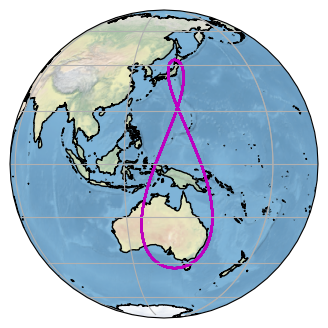

In [16]:
lon0 = 135
plt.figure(figsize=(4, 4))
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=lon0,
                                           central_latitude=0))
ax.coastlines(resolution='50m')
ax.gridlines()
ax.stock_img()

n = 24*3600//300
pos = np.zeros((n, 3))
r2d = 180/np.pi

for k in range(uGNSS.MAXSAT):
    sat = k+1
    sys, prn = sat2prn(sat)
    if sys != uGNSS.QZS:  # skip non QZSS
        continue
    for i in range(n):
        t = timeadd(t0, i*300)
        if eph is None:
            continue
        rs, dts = eph2pos(t, eph)
        pos[i, :] = ecef2pos(rs)

    plt.plot(pos[:, 1]*r2d, pos[:, 0]*r2d, 'm-', transform=ccrs.Geodetic())
plt.show()

## Showing Skyplot

In [51]:
import numpy as np
from cssrlib.gnss import Nav, ecef2pos, geodist, satazel, timediff, uGNSS
from cssrlib.ephemeris import findeph, eph2pos
from cssrlib.plot import skyplot, plot_elv
from cssrlib.rinex import rnxdec

In [52]:
navfile = '../data/SEPT078M.21P'
obsfile = '../data/SEPT078M.21O'

dec = rnxdec()
nav = Nav()
nav = dec.decode_nav(navfile, nav)

In [53]:
nep = 900
elv = np.ones((nep, uGNSS.MAXSAT))*np.nan
azm = np.ones((nep, uGNSS.MAXSAT))*np.nan
t = np.zeros(nep)*np.nan

In [55]:
if dec.decode_obsh(obsfile) >= 0:
    rr = dec.pos
    pos = ecef2pos(rr)
    for ne in range(nep):
        obs = dec.decode_obs()
        if ne == 0:
            t0 = obs.t
        t[ne] = timediff(obs.t, t0)
        for k, sat in enumerate(obs.sat):
            eph = findeph(nav.eph, obs.t, sat)
            if eph is None:
                continue
            rs, dts = eph2pos(obs.t, eph)
            r, e = geodist(rs, rr)
            azm[ne, sat-1], elv[ne, sat-1] = satazel(pos, e)
    dec.fobs.close()

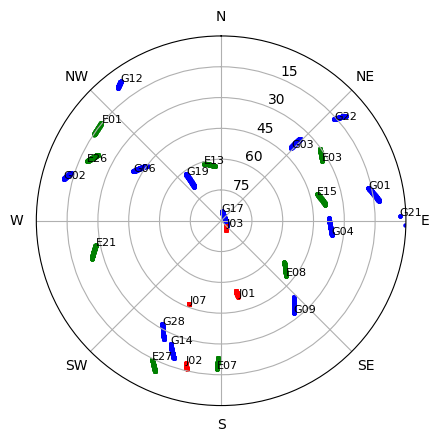

In [58]:
#plot_elv(t, elv)
nsat = skyplot(azm, elv)

## Standalone positioning

This section introduces the standalone GNSS positioning using RINEX observation.

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from cssrlib.rinex import rnxdec
from cssrlib.gnss import ecef2pos, timediff, dops, ecef2enu
from cssrlib.pntpos import stdinit, pntpos

In [45]:
xyz_ref = [-3962108.673,   3381309.574,   3668678.638]
pos_ref = ecef2pos(xyz_ref)

navfile = '../data/SEPT078M.21P'
obsfile = '../data/SEPT078M.21O'

In [46]:
dec = rnxdec()
nav = stdinit()
nav = dec.decode_nav(navfile, nav)

In [47]:
nep = 360
t = np.zeros(nep)
enu = np.zeros((nep, 3))
sol = np.zeros((nep, nav.nx))
dop = np.zeros((nep, 4))
nsat = np.zeros(nep, dtype=int)

In [48]:
if dec.decode_obsh(obsfile) >= 0:
    nav.x[0:3] = dec.pos
    for ne in range(nep):
        obs = dec.decode_obs()
        if ne == 0:
            t0 = nav.t = obs.t
        t[ne] = timediff(obs.t, t0)
        nav, az, el = pntpos(obs, nav)
        sol[ne, :] = nav.x
        dop[ne, :] = dops(az, el)
        enu[ne, :] = ecef2enu(pos_ref, sol[ne, 0:3]-xyz_ref)
        nsat[ne] = len(el)
    dec.fobs.close()

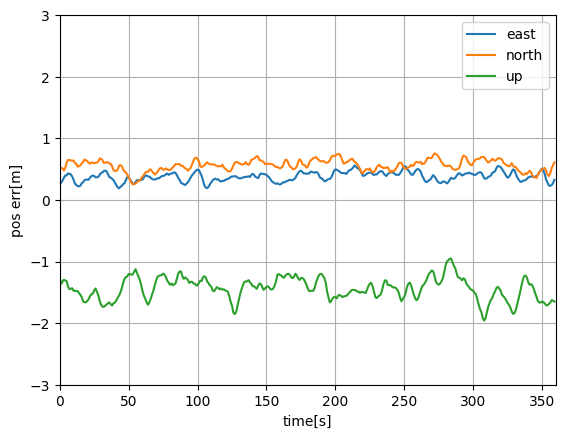

In [49]:
dmax = 3
plt.figure()
plt.plot(t, enu)
plt.ylabel('pos err[m]')
plt.xlabel('time[s]')
plt.legend(['east', 'north', 'up'])
plt.grid()
plt.axis([0, nep, -dmax, dmax])
plt.show()

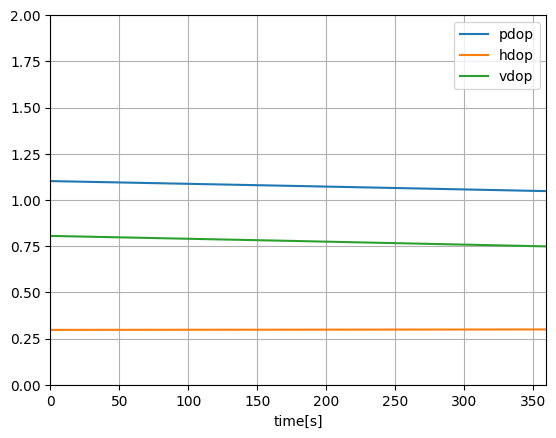

In [50]:
plt.figure()
plt.plot(t, dop[:, 1:])
plt.legend(['pdop', 'hdop', 'vdop'])
plt.grid()
plt.axis([0, nep, 0, 2])
plt.xlabel('time[s]')
plt.show()

## RTK positioning

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import cssrlib.rinex as rn
import cssrlib.gnss as gn
from cssrlib.rtk import rtkinit, relpos

In [63]:
bdir = '../data/'
navfile = bdir+'SEPT078M.21P'
obsfile = bdir+'SEPT078M.21O'
basefile = bdir+'3034078M.21O'

In [64]:
xyz_ref = [-3962108.673,   3381309.574,   3668678.638]
pos_ref = gn.ecef2pos(xyz_ref)

# rover
dec = rn.rnxdec()
nav = gn.Nav()
dec.decode_nav(navfile, nav)

# base
decb = rn.rnxdec()
decb.decode_obsh(basefile)
dec.decode_obsh(obsfile)

0

In [65]:
nep = 60

# GSI 3034 fujisawa
nav.rb = [-3959400.631, 3385704.533, 3667523.111]
t = np.zeros(nep)
enu = np.zeros((nep, 3))
smode = np.zeros(nep, dtype=int)

rtkinit(nav, dec.pos)
rr = dec.pos

In [66]:
for ne in range(nep):
    obs, obsb = rn.sync_obs(dec, decb)
    if ne == 0:
        t0 = nav.t = obs.t
    relpos(nav, obs, obsb)
    t[ne] = gn.timediff(nav.t, t0)
    sol = nav.xa[0:3] if nav.smode == 4 else nav.x[0:3]
    enu[ne, :] = gn.ecef2enu(pos_ref, sol-xyz_ref)
    smode[ne] = nav.smode

dec.fobs.close()
decb.fobs.close()

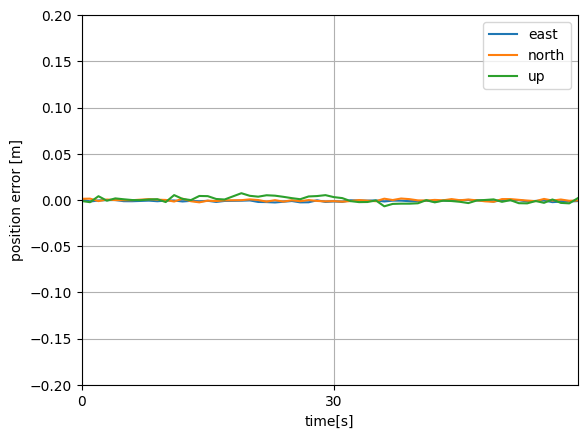

In [67]:
ylim = 0.2
plt.plot(t, enu)
plt.xticks(np.arange(0, nep+1, step=30))
plt.ylabel('position error [m]')
plt.xlabel('time[s]')
plt.legend(['east', 'north', 'up'])
plt.grid()
plt.axis([0, ne, -ylim, ylim])
plt.show()

## PPP-RTK positioning

## PPP positioning

## Reference

- [1] T. Takasu, “RTKLIB: Open Source Program Package for RTK-GPS,” FOSS4G 2009 Tokyo, Japan, 2009.